In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

Total samples: 36
Training samples: 28
Validation samples: 8
Using device: cuda
Initializing FC layers with input size: 2560
Epoch 1/15
Train Loss: 2.0947, Val Loss: 1.5756, Val Accuracy: 0.3750
Epoch 2/15
Train Loss: 0.9459, Val Loss: 1.5329, Val Accuracy: 0.5000
Epoch 3/15
Train Loss: 1.5954, Val Loss: 1.3342, Val Accuracy: 0.5000
Epoch 4/15
Train Loss: 1.1154, Val Loss: 0.9345, Val Accuracy: 0.6250
Epoch 5/15
Train Loss: 0.6072, Val Loss: 0.7527, Val Accuracy: 0.6250
Epoch 6/15
Train Loss: 0.4388, Val Loss: 0.6390, Val Accuracy: 0.7500
Epoch 7/15
Train Loss: 0.5028, Val Loss: 0.5198, Val Accuracy: 0.7500
Epoch 8/15
Train Loss: 0.3840, Val Loss: 0.2093, Val Accuracy: 1.0000
Epoch 9/15
Train Loss: 0.5404, Val Loss: 0.1599, Val Accuracy: 1.0000
Epoch 10/15
Train Loss: 0.2652, Val Loss: 0.1432, Val Accuracy: 1.0000
Epoch 11/15
Train Loss: 0.2264, Val Loss: 0.3199, Val Accuracy: 0.7500
Epoch 12/15
Train Loss: 0.1807, Val Loss: 0.0747, Val Accuracy: 1.0000
Epoch 13/15
Train Loss: 0.1088, 

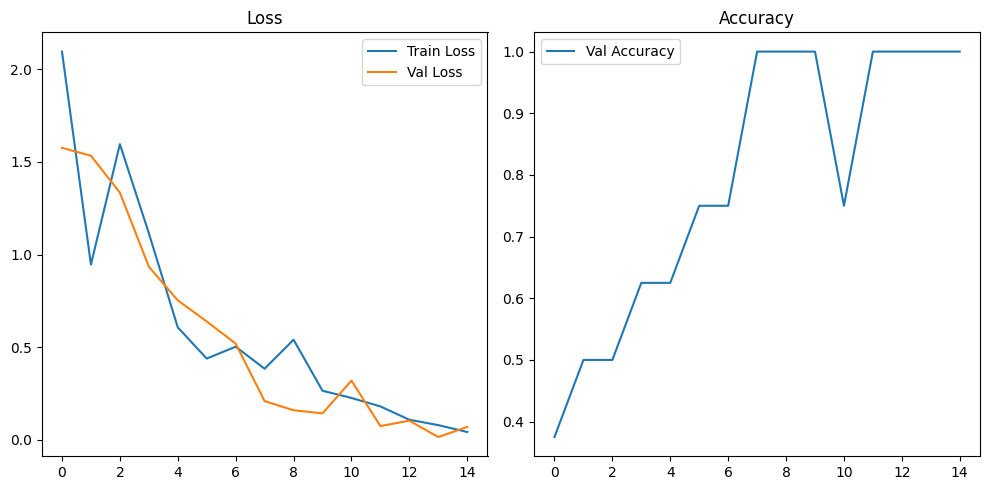

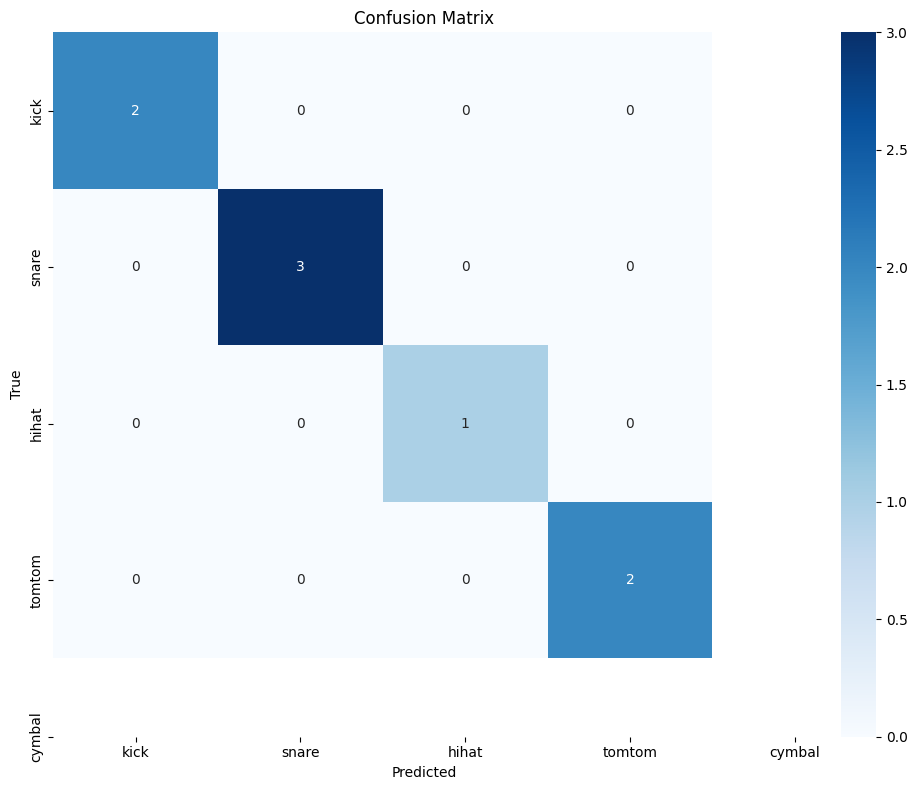

In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Define drum categories
drum_categories = ["kick", "snare", "hihat", "tomtom", "cymbal"]

# Create a mapping from category names to indices
label_map = {category: idx for idx, category in enumerate(drum_categories)}

# Define a CNN model for audio classification
class AudioCNN(nn.Module):
    def __init__(self, num_classes, n_mels=64):
        super(AudioCNN, self).__init__()
        
        # Define the model architecture
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        
        # We'll determine the actual flat_size dynamically in the first forward pass
        self.flat_size = None
        self.num_classes = num_classes
        
        # Placeholder for fully connected layers - we'll initialize these in the first forward pass
        self.fc1 = None
        self.dropout = nn.Dropout(0.5)
        self.fc2 = None
    
    def _initialize_fc_layers(self, flat_size, device):
        self.flat_size = flat_size
        self.fc1 = nn.Linear(flat_size, 256).to(device)
        self.fc2 = nn.Linear(256, self.num_classes).to(device)
    
    def forward(self, x):
        device = x.device  # Get the device of the input tensor
        
        # x shape: [batch_size, channels, frequency, time]
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        batch_size = x.size(0)
        x_flat = x.view(batch_size, -1)
        
        # Initialize FC layers if not done yet
        if self.fc1 is None:
            flat_size = x_flat.size(1)
            print(f"Initializing FC layers with input size: {flat_size}")
            self._initialize_fc_layers(flat_size, device)
        
        # Fully connected layers
        x = F.relu(self.fc1(x_flat))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# Custom dataset for drum samples
class DrumSampleDataset(Dataset):
    def __init__(self, audio_dir, sample_rate=16000, n_mels=64, n_fft=400):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = n_fft // 2
        self.max_length = int(sample_rate * 1.0)  # 1-second max length
        
        # Initialize mel spectrogram transform
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=n_fft,
            hop_length=self.hop_length,
            n_mels=n_mels
        )
        
        # Get all audio files and their labels
        self.audio_files = []
        self.labels = []
        
        # Scan through directories (assuming directory structure matches drum categories)
        for category in os.listdir(audio_dir):
            if category in label_map and os.path.isdir(os.path.join(audio_dir, category)):
                category_dir = os.path.join(audio_dir, category)
                for file in os.listdir(category_dir):
                    if file.endswith(('.wav', '.mp3', '.ogg')):
                        self.audio_files.append(os.path.join(category_dir, file))
                        self.labels.append(label_map[category])
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_file = self.audio_files[idx]
        label = self.labels[idx]
        
        # Load audio file
        waveform, sample_rate = torchaudio.load(audio_file)
        
        # Convert to mono if needed
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        # Resample if needed
        if sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, self.sample_rate)
            waveform = resampler(waveform)
        
        # Pad or trim to fixed length
        if waveform.shape[1] < self.max_length:
            # Pad with zeros
            padding = self.max_length - waveform.shape[1]
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        else:
            # Random crop to max_length
            start = torch.randint(0, waveform.shape[1] - self.max_length + 1, (1,))
            waveform = waveform[:, start:start + self.max_length]
        
        # Compute mel spectrogram
        melspec = self.mel_spec(waveform)
        
        # Convert to decibels
        melspec = torchaudio.transforms.AmplitudeToDB()(melspec)
        
        # Normalize
        melspec = (melspec - melspec.mean()) / (melspec.std() + 1e-8)
        
        return {
            "input": melspec,  # Shape: [1, n_mels, time]
            "label": torch.tensor(label)
        }

# Function to create and perform data split
def create_data_loaders(audio_dir, batch_size=16, train_ratio=0.8):
    # Create the dataset
    dataset = DrumSampleDataset(audio_dir)
    
    # Split into train and validation sets
    train_size = int(train_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader, dataset

# Define training function
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=2, factor=0.5
    )
    # Note: We'll manually print when learning rate changes
    
    # Training loop
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        
        for batch in train_loader:
            inputs = batch["input"].to(device)
            labels = batch["label"].to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch["input"].to(device)
                labels = batch["label"].to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predictions = torch.max(outputs, 1)
                
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        # Store previous learning rate to check for changes
        prev_lr = optimizer.param_groups[0]['lr']
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Check if learning rate changed
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr != prev_lr:
            print(f"Learning rate reduced from {prev_lr} to {current_lr}")
        
        # Calculate accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.4f}")
    
    # Plot training progress
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.tight_layout()
    plt.savefig('../out/classifier/training_progress.png')
    
    return model, all_preds, all_labels

# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=drum_categories,
        yticklabels=drum_categories
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('../out/classifier/confusion_matrix.png')

# Function to predict the drum type of a new audio file
def predict_drum_type(model, audio_file, sample_rate=16000, n_mels=64, n_fft=400):
    device = next(model.parameters()).device  # Get the device the model is on
    model.eval()
    
    # Load audio
    waveform, sr = torchaudio.load(audio_file)
    
    # Convert to mono if needed
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Resample if needed
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Pad or trim to fixed length
    max_length = int(sample_rate * 1.0)  # 1-second
    if waveform.shape[1] < max_length:
        padding = max_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    else:
        waveform = waveform[:, :max_length]
    
    # Compute mel spectrogram
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=n_fft // 2,
        n_mels=n_mels
    )(waveform)
    
    # Convert to decibels
    mel_spec = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    # Normalize
    mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)
    
    # Add batch dimension and move to model's device
    mel_spec = mel_spec.unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(mel_spec)
        _, prediction = torch.max(outputs, 1)
        prediction = prediction.item()
    
    predicted_category = drum_categories[prediction]
    
    # Get probabilities for all categories
    probabilities = F.softmax(outputs, dim=1)[0]
    probs_dict = {drum_categories[i]: float(probabilities[i].cpu()) for i in range(len(drum_categories))}
    
    return predicted_category, probs_dict

# Save and load model functions
def save_model(model, path="../our/classifier/drum_classifier_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path="../our/classifier/drum_classifier_model.pth", device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Create model with dummy values - we'll update the FC layers after loading
    model = AudioCNN(num_classes=len(drum_categories))
    model = model.to(device)
    
    # Load the state dict
    state_dict = torch.load(path, map_location=device)
    
    # Check if fc1 and fc2 are in the state dict to determine input/output dimensions
    if 'fc1.weight' in state_dict:
        flat_size = state_dict['fc1.weight'].size(1)
        num_classes = state_dict['fc2.weight'].size(0)
        
        # Initialize FC layers with correct dimensions
        model._initialize_fc_layers(flat_size, device)
        
        # Now load the state dict
        model.load_state_dict(state_dict)
    else:
        # If the model structure can't be determined, we'll need to run a forward pass first
        print("Model structure couldn't be determined from saved state. Run a forward pass first.")
    
    model.eval()
    return model

# Main execution code
def main():
    # Create output directory if it doesn't exist
    os.makedirs("../out/classifier", exist_ok=True)

    # Set directories
    audio_dir = "../data/samples"  # Update this path
    
    # Create data loaders
    train_loader, val_loader, dataset = create_data_loaders(audio_dir, batch_size=8)
    
    print(f"Total samples: {len(dataset)}")
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    
    # Choose device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Create model and move to device first
    model = AudioCNN(num_classes=len(drum_categories))
    model = model.to(device)
    
    # Run a single batch through the model to initialize FC layers
    if len(train_loader) > 0:
        sample_batch = next(iter(train_loader))
        sample_inputs = sample_batch["input"].to(device)
        with torch.no_grad():
            _ = model(sample_inputs)  # This will trigger FC layer initialization
    else:
        print("Warning: No training data found. Cannot initialize model.")
        return
    
    model, all_preds, all_labels = train_model(
        model, 
        train_loader, 
        val_loader, 
        num_epochs=15,
        learning_rate=0.001
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(all_labels, all_preds)
    
    # Save the trained model
    save_model(model, "../out/classifier/drum_classifier_model.pth")
    
    # Example prediction
    example_file = "drums/samples/snare/snare_1.wav"  # Update this path
    if os.path.exists(example_file):
        prediction, probabilities = predict_drum_type(model, example_file)
        print(f"Predicted drum type: {prediction}")
        for category, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
            print(f"{category}: {prob:.4f}")

if __name__ == "__main__":
    main()